# Preprocesamiento Datos Casal La Montserratina

In [48]:
#Data Manipulation
import pandas as pd
import numpy as np

# Plots
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Utilities
import os
import calendar
import holidays
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

#Parameters Dict
parameters = {
    "paths": {
        "2022_01_06": "../data/data_casal_montserratina/Casal_Montserratina_202201_202206.csv",
        "2022_07_12": "../data/data_casal_montserratina/Casal_Montserratina_202207_202212.csv",
        "2023_01_06": "../data/data_casal_montserratina/Casal_Montserratina_202301_202306.csv",
        "2023_07_12": "../data/data_casal_montserratina/Casal_Montserratina_202307_202312.csv",
        "2024_01_05": "../data/data_casal_montserratina/Casal_Montserratina_202401_202405.csv",
    }
}

### Funciones

In [49]:
# TODO cambiar la funcion para que le pase solo el DF. que tome la fecha como parametro por defecto y le paso el valor de Y
def grafico_zoom(df_x, df_y, title, yaxis_title, filename):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_x, 
        y=df_y, 
        mode='lines', 
        name='Line', 
        connectgaps=False 
    ))

    fig.update_layout(
        title=title,  
        xaxis_title="Fecha",
        yaxis_title=yaxis_title, 
        xaxis_tickangle=0, 
        showlegend=False
    )
    # # Guardar la imagen en el archivo especificado
    fig.write_image(f"../results/{filename}.png", format="png", scale=2, width=1000)
    fig.show()

In [50]:
#Prints the NaN Values per Column of a dataset
def checkNaNValues(df):
    return print(f"NaN Count per Column", df.isna().any(axis=1).sum())

In [51]:
#Checks if there is any missing time series
def checkMissingData(df, date_column):
    min_date = df[date_column].min()
    max_date = df[date_column].max()

    date_range = pd.date_range(start=min_date, end=max_date, freq='h')
    missing_dates = date_range[~date_range.isin(df[date_column])]
    print(f"Number of Missing Values: {missing_dates.shape[0]}")
    return None if missing_dates.shape[0] == 0 else missing_dates, date_range

In [52]:
def getNumberOfOutliersPerColumn(df, columns_list):
    for col in columns_list:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        #Calcular los límites inferiores y superiores para identificar outliers
        lim_inf = q1 - (1.5 * iqr)
        lim_sup = q3 + (1.5 * iqr)

        outliers = ((df[col] < lim_inf) | (df[col] > lim_sup))
        print(f"For {col} Column, the Number of Outliers is {outliers.sum()}. Sus limites son {lim_inf} y {lim_sup}.\n")

### Load Data

In [53]:
ruta_data = "../data/data_casal_montserratina/"

In [54]:
df_1 = pd.read_csv(parameters["paths"]["2022_01_06"], delimiter=";")
df_2 = pd.read_csv(parameters["paths"]["2022_07_12"], delimiter=";")
df_3 = pd.read_csv(parameters["paths"]["2023_01_06"], delimiter=";")
df_4 = pd.read_csv(parameters["paths"]["2023_07_12"], delimiter=";")
df_5 = pd.read_csv(parameters["paths"]["2024_01_05"], delimiter=";")

In [55]:
# hago un concat de los 4 datasets, para Unir los DataFrames uno a continuación del otro
df = pd.concat([df_1, df_2, df_3, df_4, df_5], ignore_index=True)
df.head()

TimeStamp  Valor  Període tarifari Tipus lectura
0  01/01/2022 00:00      6                 6          Real
1  01/01/2022 01:00      6                 6          Real
2  01/01/2022 02:00      5                 6          Real
3  01/01/2022 03:00      7                 6          Real
4  01/01/2022 04:00      7                 6          Real

In [56]:
df["TimeStamp"] = pd.to_datetime(df["TimeStamp"], format="%d/%m/%Y %H:%M")
df = df.drop(columns=["Tipus lectura", "Període tarifari"])
df.rename(columns={'TimeStamp': 'Date', 
                   'Valor': 'Consumo'}, inplace=True)

### Missing values

In [57]:
checkNaNValues(df)
missing_dates, date_range = checkMissingData(df, 'Date')

NaN Count per Column 0
Number of Missing Values: 2906


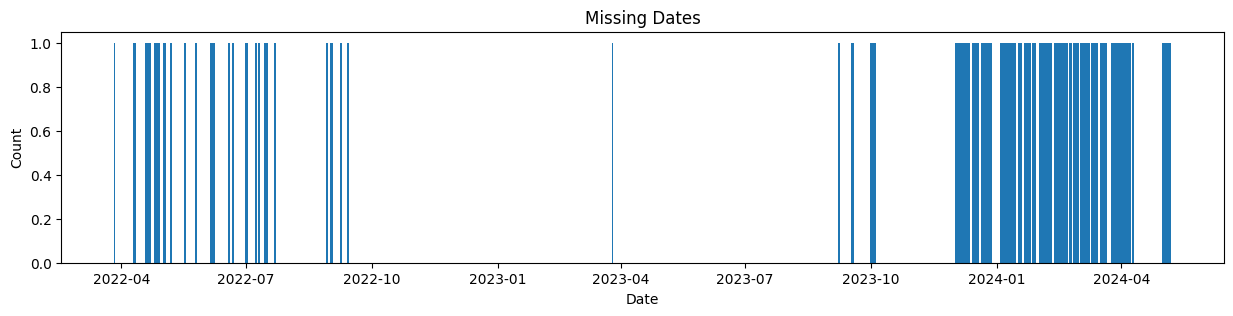

In [58]:
plt.figure(figsize=(15, 3))
plt.bar(missing_dates, [1] * len(missing_dates))
plt.title("Missing Dates")
plt.xlabel("Date")
plt.ylabel("Count")

plt.savefig("../results/missing_dates.png", bbox_inches='tight', dpi=300)
plt.show()

Un ejemplo de fechas faltantes; notar que entre las 01:00 y las 03:00 no hay datos. 

In [59]:
print(df[(df["Date"]>="2022-03-27 00:00:00") & (df["Date"]<"2022-03-27 05:00:00")])

                    Date  Consumo
2040 2022-03-27 00:00:00        2
2041 2022-03-27 01:00:00        3
2042 2022-03-27 03:00:00        2
2043 2022-03-27 04:00:00        2


### Rellenar los huecos de Date

Antes de mostrar la gráfica del timeseries, hay que rellenar los huecos que haya en la columna de fechas, sinó las herramientas para graficar hacer interpolación de los datos faltantes, en definitiva, no se perciben los huecos. 

In [60]:
df = df.drop_duplicates(keep=False) # duplicados no hay, pero surgió un par de veces ese error al hacer el reindex. 

df.set_index("Date", inplace=True)

# Reindexa el DataFrame con el nuevo rango de fechas y rellena los valores faltantes con NaN
data_reindexed = df.reindex(date_range)

data_reindexed.reset_index(inplace=True)
data_reindexed.rename(columns={'index': 'Date'}, inplace=True) 

Ya no hay huecos en la columna Date, ahora aparecen rellenas!... con Nulls, tiny bam! 

In [61]:
print(data_reindexed[(data_reindexed["Date"]>="2022-03-27 00:00:00") & (data_reindexed["Date"]<"2022-03-27 05:00:00")])

                    Date  Consumo
2040 2022-03-27 00:00:00      2.0
2041 2022-03-27 01:00:00      3.0
2042 2022-03-27 02:00:00      NaN
2043 2022-03-27 03:00:00      2.0
2044 2022-03-27 04:00:00      2.0


### Asignación de NaN´s 

Antes de hacer la interpolación, quiero entender como están distribuidos esos grupos de NaN´s a lo largo del DF. Lo que me interesa es poder aplicar interpolación en los huecos pequeños (que no suma muhco error) y dejar tal cual los huecos grandes.

In [62]:
def plot_consecutive_nans(df, column):
    """
    Cuenta y grafica los NaNs consecutivos en una columna específica de un DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame que contiene la columna a analizar.
    column (str): Nombre de la columna que se va a analizar.
    """
    if column not in df.columns:
        raise KeyError(f"La columna '{column}' no está presente en el DataFrame.")
    
    sr = df[column]
    nans = sr.isna()
    consecutive_nans = []
    count = 0

    for nan in nans:
        if nan:
            count += 1
        elif count > 0:
            consecutive_nans.append(count)
            count = 0
    
    if count > 0:
        consecutive_nans.append(count)
    if not consecutive_nans:
        print("No hay NaNs consecutivos en los datos.")
        return

    count_series = pd.Series(consecutive_nans).value_counts().sort_index()
    print(count_series)

    ax = sns.barplot(x=count_series.index, y=count_series.values)
    ax.set_title('Consecutive NaNs')
    ax.set_xlabel('Number of consecutive NaNs')
    ax.set_ylabel('Count')

    plt.show()


1       4
24     28
48      7
72      6
96      7
120     4
144     1
168     1
Name: count, dtype: int64


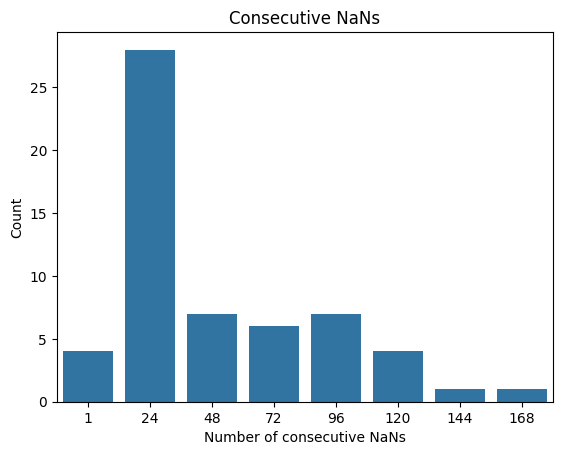

In [63]:
plot_consecutive_nans(data_reindexed, "Consumo")

Veo que en general, huecos (como filas de NaN´s consecutivos) se agurpan en bloques de 24. Dado los datos vienen en frecuencia horaria, 24 NaN´s seguidos corresponden a 1 día, y 168 a 7 días. 

Tenía intención de hacer una función que haga interpolación **SOLO** de los bloques de NaN´s cortos, como para no afectar demasiado la función objetivo.
Puede hacerse interpolación de los pocos huecos de 1 hora (solo afectaría a 4 huecos), y el siguiente treshold sería ya de interpolar 24 horas... interpolaré hasta los bloques de 24 horas.

In [64]:
# def interpolate_with_threshold(df, column, threshold):
#     # Create a mask of NaNs
#     mask = df[column].isna()

#     # Identify groups of consecutive NaNs
#     mask_diff = mask.diff().fillna(False)
#     groups = mask_diff.cumsum()[mask]

#     # Count the size of each group
#     group_counts = groups.map(groups.value_counts())

#     # Create a mask for groups that are less than or equal to the threshold
#     interpolate_mask = group_counts <= threshold

#     # Interpolate only where the mask is True
#     df[column] = df[column].mask(mask).interpolate().where(interpolate_mask, df[column])

#     # Count and print the number of interpolated and not interpolated values
#     interpolated_count = interpolate_mask.sum()
#     not_interpolated_count = mask.sum() - interpolated_count

#     print(f"Interpolated count: {interpolated_count}")
#     print(f"Not interpolated count: {not_interpolated_count}")

# interpolate_with_threshold(data_reindexed, 'Consumo',5)

In [65]:
data_reindexed

Date  Consumo
0     2022-01-01 00:00:00      6.0
1     2022-01-01 01:00:00      6.0
2     2022-01-01 02:00:00      5.0
3     2022-01-01 03:00:00      7.0
4     2022-01-01 04:00:00      7.0
...                   ...      ...
20587 2024-05-07 19:00:00     10.0
20588 2024-05-07 20:00:00      7.0
20589 2024-05-07 21:00:00      4.0
20590 2024-05-07 22:00:00      2.0
20591 2024-05-07 23:00:00      2.0

[20592 rows x 2 columns]

In [66]:
def rellenarHuecos(df, max_gap=24):
    new_df = df.copy(deep=True)
    #Obtenemos un dataframe con aquellas filas de demanda nula, en huecos de 
    #nulos menores o iguales a 24 horas
    is_null = new_df["Consumo"].isnull()
    null_groups = (is_null != is_null.shift()).cumsum()
    group_sizes = is_null.groupby(null_groups).sum()
    valid_groups = group_sizes[group_sizes <= max_gap].index
    valid_mask = null_groups.isin(valid_groups) & is_null
    filtered_df = new_df[valid_mask].copy(deep=True)

    #1 Week
    filtered_df["consumo_1w"] = new_df["Consumo"].shift(periods=24*7).fillna(0)

    #1 Week
    filtered_df["consumo_2w"] = new_df["Consumo"].shift(periods=24*14).fillna(0)

    #3 Week
    filtered_df["consumo_3w"] = new_df["Consumo"].shift(periods=24*21).fillna(0)

    #3 Week
    filtered_df["consumo_4w"] = new_df["Consumo"].shift(periods=24*28).fillna(0)

    #Mean
    consumo_4w_mean = (filtered_df["consumo_1w"] + filtered_df["consumo_2w"] + filtered_df["consumo_3w"] + filtered_df["consumo_4w"]) / 4
    
    filtered_df['demanda_shifted'] = consumo_4w_mean[filtered_df.index]
    print(filtered_df)
    return filtered_df
filtered_df = rellenarHuecos(data_reindexed)

data_reindexed.loc[filtered_df.index, 'Consumo'] = filtered_df['demanda_shifted']

                     Date  Consumo  consumo_1w  consumo_2w  consumo_3w  \
2042  2022-03-27 02:00:00      NaN         3.0         2.0         7.0   
2376  2022-04-10 00:00:00      NaN         3.0         2.0         2.0   
2377  2022-04-10 01:00:00      NaN         2.0         3.0         2.0   
2378  2022-04-10 02:00:00      NaN         2.0         0.0         3.0   
2379  2022-04-10 03:00:00      NaN         3.0         2.0         2.0   
...                   ...      ...         ...         ...         ...   
19915 2024-04-09 19:00:00      NaN         0.0         0.0         0.0   
19916 2024-04-09 20:00:00      NaN         0.0         0.0         0.0   
19917 2024-04-09 21:00:00      NaN         0.0         0.0         0.0   
19918 2024-04-09 22:00:00      NaN         0.0         0.0         0.0   
19919 2024-04-09 23:00:00      NaN         0.0         0.0         0.0   

       consumo_4w  demanda_shifted  
2042          9.0             5.25  
2376          3.0             2.50  


48     7
72     6
96     7
120    4
144    1
168    1
Name: count, dtype: int64


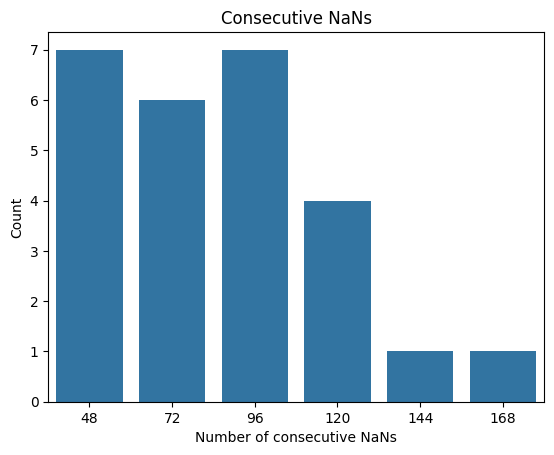

In [67]:
plot_consecutive_nans(data_reindexed, "Consumo")

In [68]:
data_reindexed

Date  Consumo
0     2022-01-01 00:00:00      6.0
1     2022-01-01 01:00:00      6.0
2     2022-01-01 02:00:00      5.0
3     2022-01-01 03:00:00      7.0
4     2022-01-01 04:00:00      7.0
...                   ...      ...
20587 2024-05-07 19:00:00     10.0
20588 2024-05-07 20:00:00      7.0
20589 2024-05-07 21:00:00      4.0
20590 2024-05-07 22:00:00      2.0
20591 2024-05-07 23:00:00      2.0

[20592 rows x 2 columns]

In [69]:
grafico_zoom(data_reindexed["Date"], data_reindexed["Consumo"],
              "Consumo Eléctrico - Casal La Monserratina", "Consumo [kWh]", filename="curva_demanda_original")

## Gaficas varias de la variable Consumo

### Consumo resampleado a una semana

In [70]:
# Weekly Demand Plot
whole_df_1w = df.resample('1W').mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x=whole_df_1w.index, y=whole_df_1w["Consumo"], mode='lines'))
fig.update_layout(
    title = "Consumo Eléctrico (Resample 1 semana) - Casal La Monserratina",
    xaxis_title = "Date",
    yaxis_title = "Demand (kWh)",
    width = 850,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

### Consumo mes a mes

In [71]:
def plot_monthly_Consumo(df):
    df = df.copy(deep=True)
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)
    
    groups = df.groupby([df.index.year, df.index.month])
    num_plots = len(groups)
    fig = make_subplots(rows=6, cols=2, subplot_titles=[calendar.month_name[i] for i in range(1, 13)], horizontal_spacing=0.1, vertical_spacing=0.05)
    #colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    colors = ['blue', 'orange', 'green']

    for month in range(1, 13):
        row = (month - 1) // 2 + 1
        col = (month - 1) % 2 + 1
        monthly_data = df[df.index.month == month]
        unique_years = monthly_data.index.year.unique()
        for i, year in enumerate(unique_years):
            year_data = monthly_data[monthly_data.index.year == year]
            year_data = year_data.copy(deep=True)
            year_data.index = year_data.index.map(lambda x: x.replace(year=2022))  # Normalizar el año para superponer curvas
            fig.add_trace(
                go.Scatter(x=year_data.index, y=year_data["Consumo"], mode='lines', name=f"{year}",
                           legendgroup=f"{month}", line=dict(color=colors[i % len(colors)]), showlegend=False),
                row=row, col=col
            )
        if month == 1:
            for i, year in enumerate(unique_years):
                fig.add_trace(
                    go.Scatter(x=[None], y=[None], mode='lines', name=f"{year}",
                            legendgroup=f"{month}", line=dict(color=colors[i % len(colors)]), showlegend=True),
                    row=row, col=col
                )
                
        fig.update_xaxes(title_text="Date", row=row, col=col)
        fig.update_yaxes(title_text="Consumo (kW)", row=row, col=col)
    fig.update_layout(
        title = {
            "text": "Consumo Mes a Mes",
            'x': 0.5,
            'xanchor': 'center'
        },
        xaxis_title="Date",
        yaxis_title="Consumo (kW)",
        width=1200,
        height=2000,
        margin=dict(l=20, r=20, t=45, b=20)   
    )
    
  
    fig.show()

plot_monthly_Consumo(df)

### Slice Dataset

La idea es dejar fuera los huecos del final, ya que no aportan información y suman error a las métricas de predicción.

In [72]:
def slicer_grafico(df, fecha_cambio, title, yaxis_title, filename):
    df_descarte = df.copy(deep=True)

    # Dividir los datos en dos partes
    df_1 = df_descarte[df_descarte.Date <= pd.to_datetime(fecha_cambio)]
    df_2 = df_descarte[len(df_1):]

    fig = go.Figure()
    # Primer trazo (antes de la fecha de cambio)
    fig.add_trace(go.Scatter(
        x=df_1.Date, 
        y=df_1.Consumo, 
        mode='lines', 
        name='Parte del dataset que se utilizará', 
        connectgaps=False,
        line=dict(color='blue')  # Color azul
    ))

    # Segundo trazo (después de la fecha de cambio)
    fig.add_trace(go.Scatter(
        x=df_2.Date, 
        y=df_2.Consumo, 
        mode='lines', 
        name='Parte del dataset que se descarta', 
        connectgaps=False,
        line=dict(color='lightgrey')  # Color gris claro
    ))

    fig.update_layout(
            title=title,  
            xaxis_title="Date",
            yaxis_title=yaxis_title, 
            xaxis_tickangle=0, 
            legend=dict(
                x=0.74,  # Ajusta la posición horizontal de la leyenda (0 a 1)
                y=0.98,  # Ajusta la posición vertical de la leyenda (0 a 1)
                bgcolor='rgba(255, 255, 255, 0.5)',  # Fondo semitransparente blanco
                bordercolor='rgba(0, 0, 0, 0.5)',  # Borde semitransparente negro
                borderwidth=1  # Ancho del borde
            )
    )
    # Guardar la imagen en el archivo especificado
    fig.write_image(f"../results/{filename}.png", format="png", width=1000)

    fig.show()
slicer_grafico(data_reindexed, 
    "2023-11-30 23:00:00",  # Fecha de cambio
    title="Consumo Eléctrico con Cambio de Color", 
    yaxis_title="Consumo [kW]",
    filename="DemandaDescartada")

In [73]:
# Definir las fechas inicial y final - 'YYYY-MM-DD HH:MM:SS'.
fecha_inicial = '2022-07-02 00:00:00' # fecha donde empieza la zona "limpia"
fecha_final = '2023-11-30 23:00:00'

# Obtener el DataFrame recortado
#df_sliced = df.loc[(df.index <= pd.to_datetime(fecha_final, format='%Y-%m-%d %H:%M:%S'))]
df_sliced = df.loc[(df.index >= pd.to_datetime('2022-01-07 0:00', format='%Y-%d-%m %H:%M'))]
df_sliced = df_sliced.loc[(df_sliced.index <= pd.to_datetime('2023-01-11 0:00', format='%Y-%d-%m %H:%M'))]
df_sliced.reset_index(inplace=True)
grafico_zoom(df_sliced["Date"], df_sliced["Consumo"],
              "Consumo Eléctrico - Casal La Monserratina, de 2022 a 2024", "Consumo [kWh]", filename="curva_demanda_acotada")

In [74]:
df_sliced

Date  Consumo
0     2022-07-02 00:00:00        3
1     2022-07-02 01:00:00        2
2     2022-07-02 02:00:00        3
3     2022-07-02 03:00:00        2
4     2022-07-02 04:00:00        3
...                   ...      ...
11345 2023-10-31 20:00:00        5
11346 2023-10-31 21:00:00        3
11347 2023-10-31 22:00:00        2
11348 2023-10-31 23:00:00        2
11349 2023-11-01 00:00:00        3

[11350 rows x 2 columns]

### Outliers del df_sliced

In [75]:
getNumberOfOutliersPerColumn(df_sliced, df_sliced.columns.drop("Date"))

For Consumo Column, the Number of Outliers is 1287. Sus limites son -2.5 y 9.5.



## Smoothing w/moving average

In [76]:
# Define the window size for the rolling mean
window_size = 24*1 # datos horarios, es decir, que el window_size esta en horas.

# Calculate the rolling mean
df_sliced['Consumo_smooth_mean'] = df_sliced['Consumo'].rolling(window=window_size).mean()
df_sliced['Consumo_smooth_std'] = df_sliced['Consumo'].rolling(window=window_size).std()

In [77]:
# Create traces for original and smoothed data
trace_original = go.Scatter(
    x=df_sliced["Date"], 
    y=df_sliced['Consumo'], 
    mode='lines', 
    name='Original', 
    line=dict(color='gray'), 
    opacity=0.5 
)
trace_smoothed_mean = go.Scatter(
    x=df_sliced["Date"], 
    y=df_sliced['Consumo_smooth_mean'], 
    mode='lines', 
    name='Smoothed Mean',
    line=dict(color='blue'),
    opacity= 0.8  
)
trace_smoothed_std = go.Scatter(
    x=df_sliced["Date"], 
    y=df_sliced['Consumo_smooth_std'], 
    mode='lines', 
    name='Smoothed std',
    line=dict(color='orange'), 
    opacity=0.8   
)

# Create layout
layout = go.Layout(
    title='Original vs Smoothed Data', 
    xaxis=dict(title='Fecha'), 
    yaxis=dict(title='Consumo [kW]'),
    legend=dict(
        traceorder='normal',
        orientation='h',
        tracegroupgap=10 ,
        yanchor="top",
        y=1.1,
        xanchor="center",
        x=0.8
    ),
    margin=dict(
        l=10,
        r=10,
        t=10,
        b=10
    )
)

# Create figure
fig = go.Figure(data=[trace_original, trace_smoothed_mean, trace_smoothed_std], layout=layout)

#Save Figure
fig.write_image("../results/smooth_mean_std.png", format="png", width=1000, scale=2)
# Show figure
fig.show()

In [78]:
df_sliced.describe()

Date       Consumo  Consumo_smooth_mean  \
count                          11350  11350.000000         11327.000000   
mean   2023-03-04 06:08:35.735683072      4.336476             4.337483   
min              2022-07-02 00:00:00      0.000000             1.000000   
25%              2022-11-06 06:15:00      2.000000             2.333333   
50%              2023-03-04 11:30:00      2.000000             3.541667   
75%              2023-06-30 17:45:00      5.000000             5.291667   
max              2023-11-01 00:00:00     52.000000            33.916667   
std                              NaN      5.950541             3.141821   

       Consumo_smooth_std  
count        11327.000000  
mean             4.177614  
min              0.653863  
25%              1.974016  
50%              3.269313  
75%              5.417196  
max             18.913993  
std              3.041344

In [79]:
varianzaConsumo = round(df_sliced["Consumo"].var(),2)
print(f"Varianza del Consumo: {varianzaConsumo}")
varianzaConsumoSmoothMean = round(df_sliced["Consumo_smooth_mean"].var(),2)
print(f"Varianza del Consumo_smooth_mean: {varianzaConsumoSmoothMean}")
varianzaConsumoSmoothStd = round(df_sliced["Consumo_smooth_std"].var(),2)
print(f"Varianza del Consumo_smooth_std: {varianzaConsumoSmoothStd}")

Varianza del Consumo: 35.41
Varianza del Consumo_smooth_mean: 9.87
Varianza del Consumo_smooth_std: 9.25


In [80]:
getNumberOfOutliersPerColumn(df_sliced, df_sliced.columns.drop("Date"))

For Consumo Column, the Number of Outliers is 1287. Sus limites son -2.5 y 9.5.

For Consumo_smooth_mean Column, the Number of Outliers is 632. Sus limites son -2.1041666666666665 y 9.729166666666668.

For Consumo_smooth_std Column, the Number of Outliers is 646. Sus limites son -3.190754299507706 y 10.581966473633404.



C:\Users\ssanchez\AppData\Local\Temp\ipykernel_6244\2717874822.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




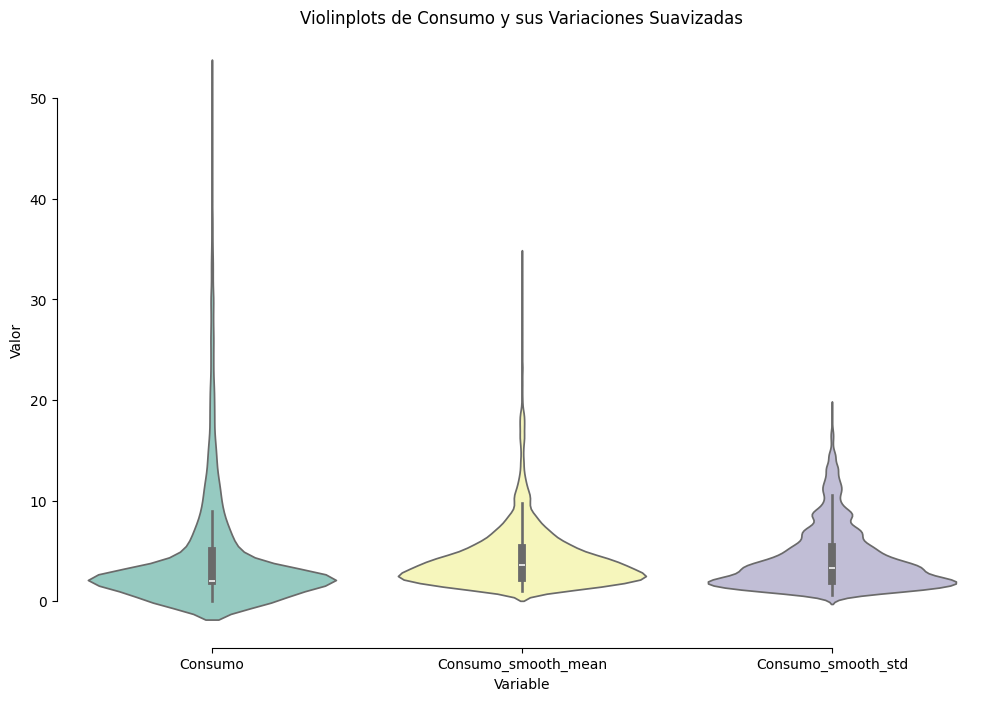

In [81]:
# Reorganizar el DataFrame en un formato largo
df_long = df_sliced.melt(id_vars=["Date"], value_vars=["Consumo", "Consumo_smooth_mean", "Consumo_smooth_std"],
                         var_name="Variable", value_name="Valor")

# Crear el gráfico de violín
plt.figure(figsize=(12, 8))
sns.violinplot(x="Variable", y="Valor", data=df_long, palette="Set3")

# Añadir un swarm plot para mostrar cada observación
#sns.swarmplot(x="Variable", y="Valor", data=df_long, color=".3", size=3)

# Ajustes adicionales de diseño
sns.despine(trim=True)
plt.xlabel("Variable")
plt.ylabel("Valor")
plt.title("Violinplots de Consumo y sus Variaciones Suavizadas")

plt.show()

No sé si se utilizará la versión de Consumo_smooth_mean, la dejo por si en el modelo de ML mejora en algo. 

## Resampling a 15 min

In [82]:
df_upsampled = df_sliced.copy(deep=True)
df_upsampled.set_index("Date", inplace=True)
df_upsampled = df_upsampled.resample('15min').interpolate(method='time')
df_upsampled

Consumo  Consumo_smooth_mean  Consumo_smooth_std
Date                                                                 
2022-07-02 00:00:00     3.00                  NaN                 NaN
2022-07-02 00:15:00     2.75                  NaN                 NaN
2022-07-02 00:30:00     2.50                  NaN                 NaN
2022-07-02 00:45:00     2.25                  NaN                 NaN
2022-07-02 01:00:00     2.00                  NaN                 NaN
...                      ...                  ...                 ...
2023-10-31 23:00:00     2.00             3.208333            2.570386
2023-10-31 23:15:00     2.25             3.218750            2.567295
2023-10-31 23:30:00     2.50             3.229167            2.564204
2023-10-31 23:45:00     2.75             3.239583            2.561113
2023-11-01 00:00:00     3.00             3.250000            2.558022

[46753 rows x 3 columns]

## Merge Consumo con PPV

In [83]:
# Load & prepatation of the DataFrame with the PV & weather data
nombre_archivo = "LaMonserratina_weather_&_PV.csv"
df_PV = pd.read_csv(os.path.join(ruta_data, nombre_archivo))
df_PV.sample(5)

Date  temperature_2m_C  relative_humidity_2m_%  \
33440   2021-12-15 08:00:00          6.621500               72.983917   
104414  2023-12-24 15:30:00         13.371500               70.049469   
35951   2022-01-10 11:45:00         10.408999               84.431953   
73504   2023-02-05 16:00:00         12.971499               54.929775   
45036   2022-04-15 03:00:00         11.121500               85.445992   

        dew_point_2m_C  apparent_temperature_C  pressure_msl_hPa  \
33440           2.1215                3.041072       1026.900024   
104414          7.9965               10.864323       1022.099976   
35951           7.8965                8.382185       1015.500000   
73504           4.1215                9.736259       1029.199951   
45036           8.7715                9.676151       1019.200012   

        surface_pressure_hPa  cloud_cover_%  cloud_cover_high_%  \
33440            1020.777527       5.400000                 0.0   
104414           1016.149170       0.000000                 0.0   
35951            1009.526062     100.000000               100.0   
73504            1023.199524       0.000000                 0.0   
45036            1013.219482       8.400001                 4.0   

        et0_fao_evapotranspiration_mm  ...  is_day  sunshine_duration_sec  \
33440                        0.030691  ...     1.0              761.26154   
104414                       0.094226  ...     1.0             3448.61230   
35951                        0.066968  ...     1.0                0.00000   
73504                        0.138908  ...     1.0             3600.00000   
45036                        0.000000  ...     0.0                0.00000   

        shortwave_radiation_W/m2  direct_radiation_W/m2  \
33440                      26.00                   14.0   
104414                    169.50                  124.5   
35951                     111.25                    1.5   
73504                     242.00                  184.0   
45036                       0.00                    0.0   

        diffuse_radiation_W/m2  direct_normal_irradiance_W/m2  \
33440                    12.00                     146.609850   
104414                   45.00                     576.622800   
35951                   109.75                       3.385505   
73504                    58.00                     675.734000   
45036                     0.00                       0.000000   

        global_tilted_irradiance_W/m2  terrestrial_radiation_W/m2  \
33440                       26.000002                   74.741806   
104414                     169.500020                  283.920620   
35951                      111.250000                  610.232400   
73504                      241.999950                  383.216160   
45036                        0.000000                    0.000000   

        Temp_interna_Modulo_C     PV_kW  
33440               23.552826  0.913550  
104414              36.365730  3.248046  
35951               22.011620  0.020641  
73504               38.435467  3.740683  
45036               22.256590  0.000000  

[5 rows x 24 columns]

In [84]:
# Preparación del df Consumo, para el merge
df_upsampled.rename(columns={
        "Consumo_smooth_mean": "Consumo_smooth_mean_kWh", 
        "Consumo_smooth_std": "Consumo_smooth_std_kWh"
    }, 
    inplace=True
)

df_upsampled.reset_index(inplace=True)
df_upsampled['Date'] = pd.to_datetime(df_upsampled['Date'])
df_PV['Date'] = pd.to_datetime(df_PV['Date'])

### Merge

In [85]:
df4 = df_upsampled.merge(df_PV, how="inner", on="Date")
df4.sample(2)

Date  Consumo  Consumo_smooth_mean_kWh  \
13053 2022-11-14 23:15:00      2.0                 3.541667   
21972 2023-02-15 21:00:00      6.0                 5.750000   

       Consumo_smooth_std_kWh  temperature_2m_C  relative_humidity_2m_%  \
13053                3.202976           15.5590               85.068390   
21972                7.103275            7.1715               88.640541   

       dew_point_2m_C  apparent_temperature_C  pressure_msl_hPa  \
13053         13.0590               15.662188       1015.800049   
21972          5.4215                5.372057       1030.599976   

       surface_pressure_hPa  ...  is_day  sunshine_duration_sec  \
13053           1009.930420  ...     0.0                    0.0   
21972           1024.467285  ...     0.0                    0.0   

       shortwave_radiation_W/m2  direct_radiation_W/m2  \
13053                       0.0                    0.0   
21972                       0.0                    0.0   

       diffuse_radiation_W/m2  direct_normal_irradiance_W/m2  \
13053                     0.0                            0.0   
21972                     0.0                            0.0   

       global_tilted_irradiance_W/m2  terrestrial_radiation_W/m2  \
13053                            0.0                         0.0   
21972                            0.0                         0.0   

       Temp_interna_Modulo_C  PV_kW  
13053              24.261044    0.0  
21972              20.472343    0.0  

[2 rows x 27 columns]

#### Demanda = Consumo + Generacion Fotovoltaica

In [86]:
df4["Demanda_kWh"] = df4["Consumo"] + df4["PV_kW"]
df4["Demanda_smooth_mean_kWh"] = df4["Consumo_smooth_mean_kWh"] + df4["PV_kW"]
df4["Demanda_smooth_std_kWh"] = df4["Consumo_smooth_std_kWh"] + df4["PV_kW"]
df4 = df4.drop(columns=["Consumo", "Consumo_smooth_mean_kWh", "Consumo_smooth_std_kWh", "PV_kW"], axis=1)
df4['Demanda_kWh'] = df4['Demanda_kWh'].apply(lambda x: 2.0 if x < 2 else x)

df4

Date  temperature_2m_C  relative_humidity_2m_%  \
0     2022-07-02 00:00:00         20.971500               81.949219   
1     2022-07-02 00:15:00         20.496500               83.861229   
2     2022-07-02 00:30:00         20.021500               85.773239   
3     2022-07-02 00:45:00         19.546501               87.685249   
4     2022-07-02 01:00:00         19.071500               89.597260   
...                   ...               ...                     ...   
46748 2023-10-31 23:00:00         13.571500               65.025040   
46749 2023-10-31 23:15:00         13.371500               65.779335   
46750 2023-10-31 23:30:00         13.171499               66.533630   
46751 2023-10-31 23:45:00         12.971499               67.287926   
46752 2023-11-01 00:00:00         12.771500               68.042221   

       dew_point_2m_C  apparent_temperature_C  pressure_msl_hPa  \
0           17.771502               23.255192       1020.200012   
1           17.659000               22.657982       1020.075012   
2           17.546501               22.060772       1019.950012   
3           17.434002               21.463564       1019.825012   
4           17.321500               20.866354       1019.700012   
...               ...                     ...               ...   
46748        7.121500               12.080925       1015.299988   
46749        7.096500               11.873585       1015.224976   
46750        7.071500               11.666244       1015.150024   
46751        7.046500               11.458904       1015.075012   
46752        7.021500               11.251564       1015.000000   

       surface_pressure_hPa  cloud_cover_%  cloud_cover_high_%  \
0               1014.413269       0.900000                0.00   
1               1014.279602       0.675000                0.00   
2               1014.145935       0.450000                0.00   
3               1014.012268       0.225000                0.00   
4               1013.878601       0.000000                0.00   
...                     ...            ...                 ...   
46748           1009.392944      15.300001               17.00   
46749           1009.314270      16.725000               12.75   
46750           1009.235596      18.150002                8.50   
46751           1009.156860      19.575000                4.25   
46752           1009.078186      21.000000                0.00   

       et0_fao_evapotranspiration_mm  ...  shortwave_radiation_W/m2  \
0                           0.000000  ...                       0.0   
1                           0.000000  ...                       0.0   
2                           0.000000  ...                       0.0   
3                           0.000000  ...                       0.0   
4                           0.000000  ...                       0.0   
...                              ...  ...                       ...   
46748                       0.010180  ...                       0.0   
46749                       0.009510  ...                       0.0   
46750                       0.008841  ...                       0.0   
46751                       0.008171  ...                       0.0   
46752                       0.007502  ...                       0.0   

       direct_radiation_W/m2  diffuse_radiation_W/m2  \
0                        0.0                     0.0   
1                        0.0                     0.0   
2                        0.0                     0.0   
3                        0.0                     0.0   
4                        0.0                     0.0   
...                      ...                     ...   
46748                    0.0                     0.0   
46749                    0.0                     0.0   
46750                    0.0                     0.0   
46751                    0.0                     0.0   
46752                    0.0                     0.0   

       direct_normal_irradiance_W/m2  global

Text(0.5, 0, 'Consumo [kW]')

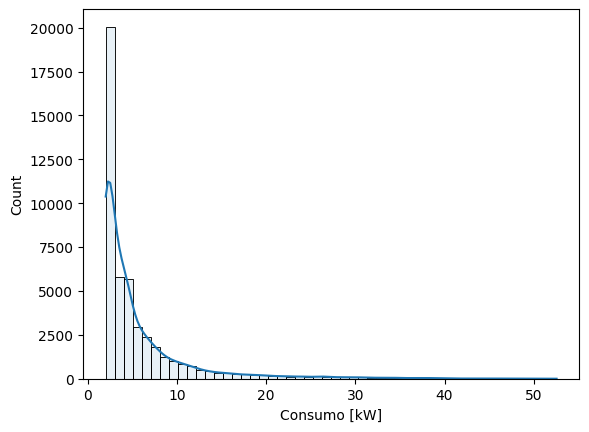

In [87]:
sns.histplot(data=df4, x="Demanda_kWh", bins=50, alpha=0.1, kde=True)  # Histograma o KDE
plt.xlabel("Consumo [kW]")

# TODO agregar otra version de este histograma

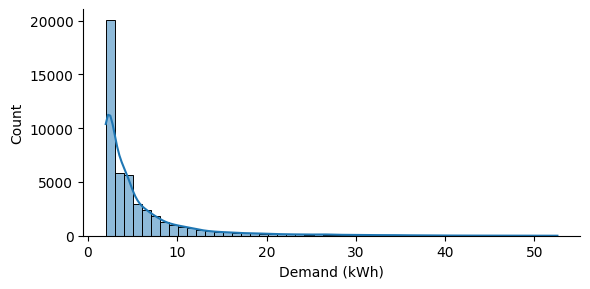

In [88]:
fg = sns.displot(df4['Demanda_kWh'], height=3, aspect= 2, bins=50, kde=True)
fg.set_axis_labels("Demand (kWh)", "Count")

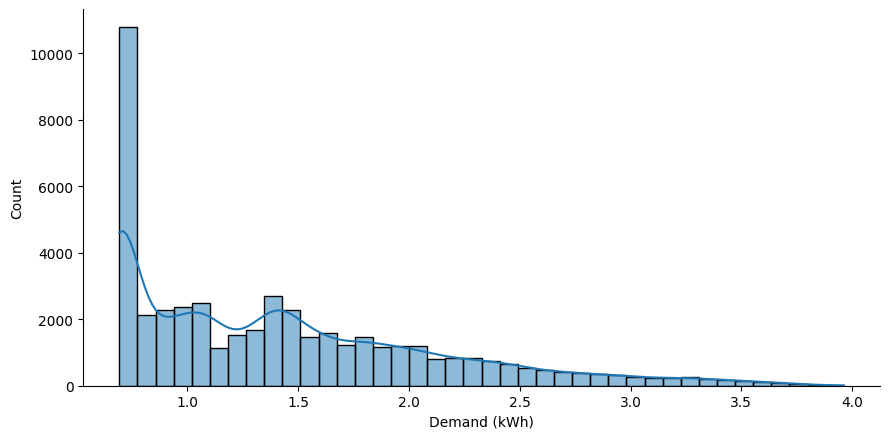

In [89]:
log_df = df4.copy(deep=True)
log_df['Demanda_kWh'] = log_df['Demanda_kWh'].apply(lambda x: 2.0 if x < 2 else x)
log_df["Demanda_kWh_log"] = np.log(log_df["Demanda_kWh"])
fg = sns.displot(log_df['Demanda_kWh_log'], height=4.5, aspect= 2, bins=40, kde=True)
fg.set_axis_labels("Demand (kWh)", "Count")
#fg.savefig("../results/distplot_quant_trans.png")

### Variables Exógenas

In [90]:
df4["Year"] = df4["Date"].dt.year
df4["Month"] = df4["Date"].dt.month
df4["Hour"] = df4["Date"].dt.hour
df4["DayOfWeek"] = df4["Date"].dt.day_of_week
df4["DayOfYear"] = df4["Date"].dt.day_of_year
df4["Day"] = df4["Date"].dt.day

In [91]:
#Sine and Cosine Transformations
def cyclical_encoding(df, cycle_length_list, columns):
    for col, cycle_length in zip(columns, cycle_length_list):
        if df[col].min == 0:
            df[f"{col}_sin"] = np.sin((df[col] / cycle_length) * np.pi * 2).round(4)
            df[f"{col}_cos"] = np.cos((df[col] / cycle_length) * np.pi * 2).round(4)
        else:
            df[f"{col}_sin"] = np.sin(((df[col] - 1) / cycle_length) * np.pi * 2).round(4)
            df[f"{col}_cos"] = np.cos(((df[col] - 1) / cycle_length) * np.pi * 2).round(4)
    return df

In [92]:

#Add isWeekend Column based in DayOfTheWeek Value
df4["isWeekend"] = df4["DayOfWeek"].isin([5, 6])

cycle_lengths = [24, 7, 12, 365]
cols = ["Hour", "DayOfWeek", "Month", "DayOfYear"]

df4 = cyclical_encoding(df4, cycle_lengths, cols)

df4.sample(3)

Date  temperature_2m_C  relative_humidity_2m_%  \
40959 2023-09-01 15:45:00         25.684002               68.798782   
7256  2022-09-15 14:00:00         27.871500               55.590202   
19418 2023-01-20 06:30:00          5.846499               88.334251   

       dew_point_2m_C  apparent_temperature_C  pressure_msl_hPa  \
40959       19.521500               27.012740       1015.875000   
7256        18.171501               30.507210       1010.700012   
19418        4.046500                3.684585       1012.150024   

       surface_pressure_hPa  cloud_cover_%  cloud_cover_high_%  \
40959           1010.203308      29.625000               91.25   
7256            1005.097961      11.700001               13.00   
19418           1006.098572       2.400000                0.00   

       et0_fao_evapotranspiration_mm  ...  Day  isWeekend  Hour_sin  Hour_cos  \
40959                       0.326057  ...    1      False   -0.5000   -0.8660   
7256                        0.453435  ...   15      False   -0.2588   -0.9659   
19418                       0.000000  ...   20      False    0.9659    0.2588   

       DayOfWeek_sin  DayOfWeek_cos  Month_sin  Month_cos  DayOfYear_sin  \
40959         0.4339        -0.9010     -0.866       -0.5        -0.8631   
7256          0.9749        -0.2225     -0.866       -0.5        -0.9587   
19418         0.4339        -0.9010      0.000        1.0         0.3213   

       DayOfYear_cos  
40959        -0.5050  
7256         -0.2844  
19418         0.9470  

[3 rows x 41 columns]

In [93]:
def generateHolidayVar(df):
    df["Reduced_Date"] = df["Date"].dt.date
    list_holidays = holidays.Spain(prov="CT", years=list(df["Year"].unique()))
    list_holidays_dates = np.array(list(list_holidays.keys()), dtype='datetime64')
    df["isHoliday"] = df["Reduced_Date"].isin(list_holidays_dates)
    df = df.drop('Reduced_Date', axis=1)
    return df

df4 = generateHolidayVar(df4)
display(df4[["Date", "isHoliday"]].sample(5))

Date  isHoliday
42090 2023-09-13 10:30:00      False
32613 2023-06-06 17:15:00      False
32833 2023-06-09 00:15:00      False
4287  2022-08-15 15:45:00       True
21049 2023-02-06 06:15:00      False

# Plots

## Consumo por mes

In [94]:
"""
# fig, ax = plt.subplots(figsize=(20, 8))
# df4.boxplot(column='Consumo_kWh', by='Month', ax=ax)
# df4.groupby('Month')['Consumo_kWh'].mean().plot(style='o-', linewidth=.8, ax=ax)
# ax.set_ylabel('Consumo [kWh]')
# ax.set_title("Consumo promedio Mensual")
# fig.suptitle('')


# # Crear el gráfico de líneas
# fig, ax = plt.subplots(figsize=(20, 8))
# # Graficar cada variable
# ax.plot(df4.index, df4['Consumo_kWh'], label='Consumo [kWh]', linewidth=1, alpha=0.5) #, marker='o'
# ax.plot(df4.index, df4['Consumo_smooth_mean_kWh'], label='Consumo Smooth Mean [kWh]',  linestyle='--', linewidth=1) # marker='s',
# ax.plot(df4.index, df4['Consumo_smooth_std_kWh'], label='Consumo Smooth Std [kWh]', linestyle='-.', linewidth=1) # , marker='^'
# # Añadir etiquetas y título
# ax.set_ylabel('Consumo [kWh]')
# ax.set_title('Consumo Promedio Mensual')
# ax.legend()
# # Mostrar el gráfico
# plt.show()

# Configurar las posiciones de las barras
bar_width = 0.2
index = np.arange(len(df_grouped))

# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar cada variable
bar1 = ax.bar(index, df_grouped['Consumo_kWh'], bar_width, label='Consumo [kWh]')
bar2 = ax.bar(index + bar_width, df_grouped['Consumo_smooth_mean_kWh'], bar_width, label='Consumo Smooth Mean [kWh]')
bar3 = ax.bar(index + 2 * bar_width, df_grouped['Consumo_smooth_std_kWh'], bar_width, label='Consumo Smooth Std [kWh]')

# Añadir etiquetas y título
ax.set_xlabel('Month')
ax.set_ylabel('Consumo [kWh]')
ax.set_title('Consumo Promedio Mensual')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(df_grouped['Month'].astype(str))
ax.legend()

# Mostrar el gráfico
plt.show()
"""

'\n# fig, ax = plt.subplots(figsize=(20, 8))\n# df4.boxplot(column=\'Consumo_kWh\', by=\'Month\', ax=ax)\n# df4.groupby(\'Month\')[\'Consumo_kWh\'].mean().plot(style=\'o-\', linewidth=.8, ax=ax)\n# ax.set_ylabel(\'Consumo [kWh]\')\n# ax.set_title("Consumo promedio Mensual")\n# fig.suptitle(\'\')\n\n\n# # Crear el gráfico de líneas\n# fig, ax = plt.subplots(figsize=(20, 8))\n# # Graficar cada variable\n# ax.plot(df4.index, df4[\'Consumo_kWh\'], label=\'Consumo [kWh]\', linewidth=1, alpha=0.5) #, marker=\'o\'\n# ax.plot(df4.index, df4[\'Consumo_smooth_mean_kWh\'], label=\'Consumo Smooth Mean [kWh]\',  linestyle=\'--\', linewidth=1) # marker=\'s\',\n# ax.plot(df4.index, df4[\'Consumo_smooth_std_kWh\'], label=\'Consumo Smooth Std [kWh]\', linestyle=\'-.\', linewidth=1) # , marker=\'^\'\n# # Añadir etiquetas y título\n# ax.set_ylabel(\'Consumo [kWh]\')\n# ax.set_title(\'Consumo Promedio Mensual\')\n# ax.legend()\n# # Mostrar el gráfico\n# plt.show()\n\n# Configurar las posiciones de las bar

In [95]:
# TODO guardar
# TODO cmabiar a linechart? u otro tipo de grafico que muestre algo mejor.

## Demanda total por día

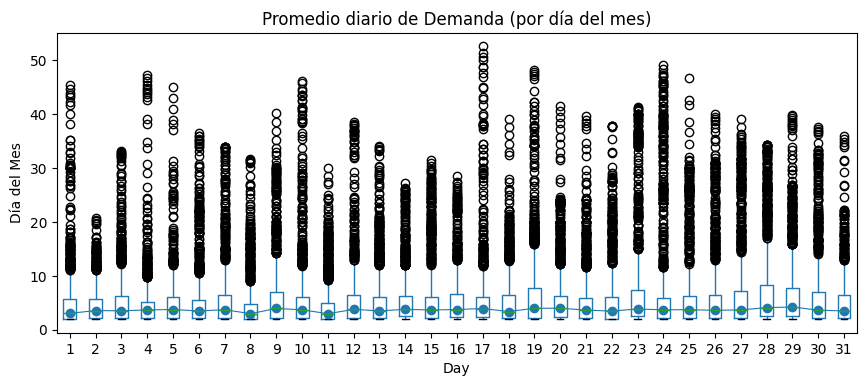

In [96]:
fig, ax = plt.subplots(figsize=(10, 4))
df4.boxplot(column='Demanda_kWh', by='Day', ax=ax)
df4.groupby('Day')['Demanda_kWh'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Demanda [kWh]')
ax.set_ylabel('Día del Mes')
ax.set_title("Promedio diario de Demanda (por día del mes)")
fig.suptitle('')
plt.savefig("../results/demanda_dia.png", bbox_inches='tight', dpi=300)

In [97]:
# TODO cmabiar a linechart? u otro tipo de grafico que muestre algo mejor. 

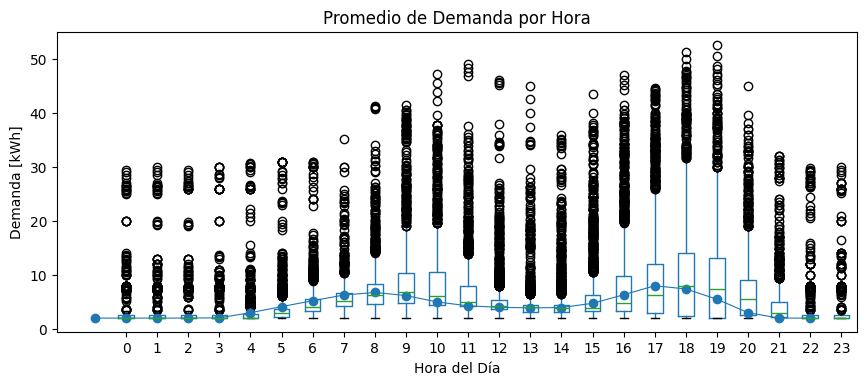

In [98]:
fig, ax = plt.subplots(figsize=(10, 4))
df4.boxplot(column='Demanda_kWh', by='Hour', ax=ax)
df4.groupby('Hour')['Demanda_kWh'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Demanda [kWh]')
ax.set_xlabel('Hora del Día')
ax.set_title("Promedio de Demanda por Hora")
fig.suptitle('')
plt.savefig("../results/demanda_hora.png", bbox_inches='tight', dpi=300)

In [99]:
# TODO cambiar a linechart?.
# TODO guardar

## Demand per Day and Season

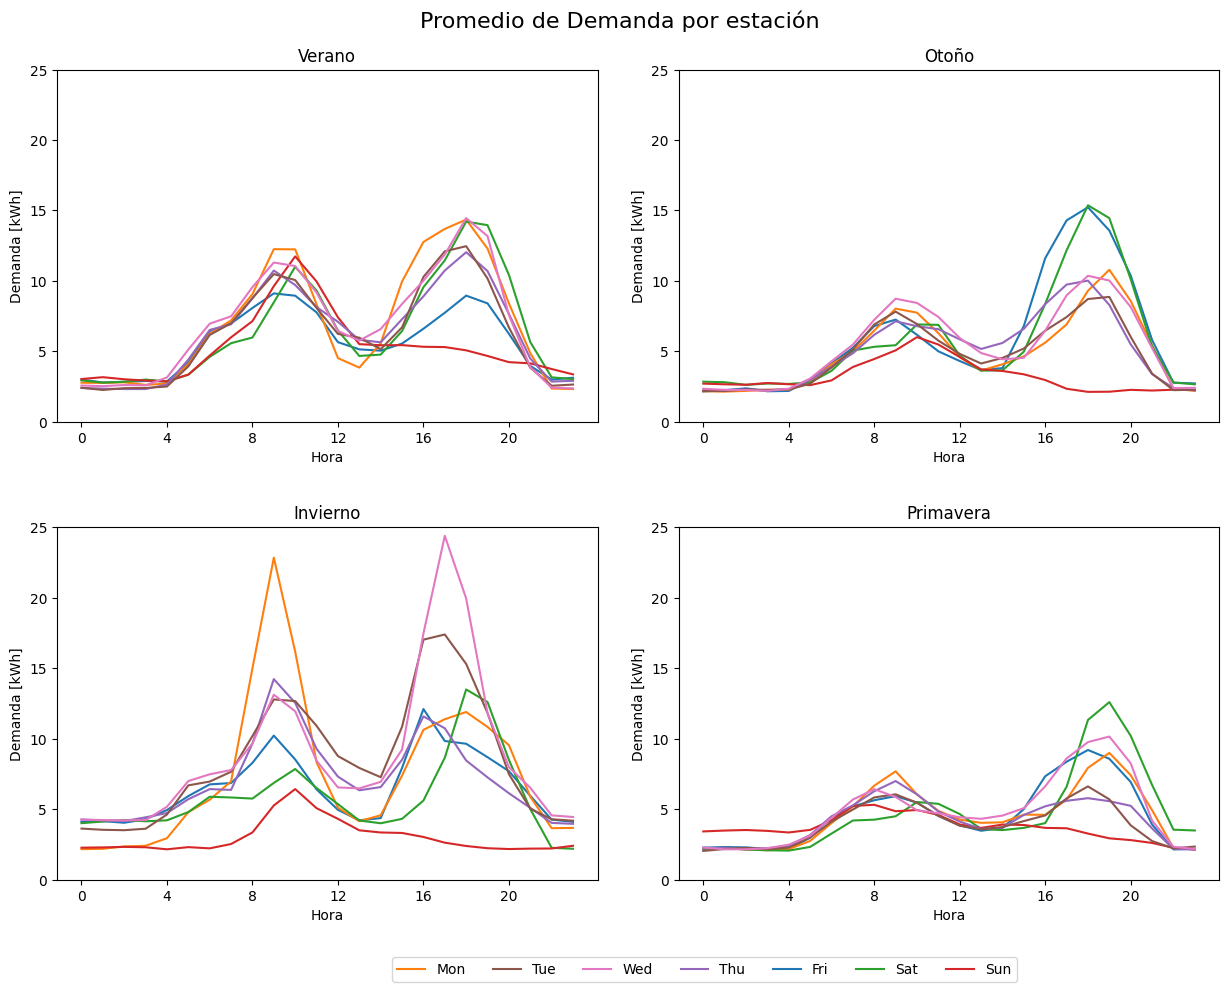

In [100]:
days_mapping = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df4["Day"] = df4["DayOfWeek"].map(days_mapping)
df4["Season"] = df4["Month"].apply(
    lambda x: (
        1 if x in [3, 4, 5] #Spring
        else 2 if x in [6, 7, 8] #Summer
        else 3 if x in [9, 10, 11] #Autumn
        else 0 #Winter
    )
)
fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.15, hspace=0.3, top=0.92)
fig.suptitle("Promedio de Demanda por estación", fontsize=16)

fig.set_figheight(10)
fig.set_figwidth(15)

ymin, ymax = 0, 25

#Season Summer
df4.loc[df4["Season"] == 2] \
    .groupby([df4.loc[df4["Season"] == 2]["Hour"], 'Day'])["Demanda_kWh"].mean().unstack().plot(
        ax=axes[0, 0], ylim=(ymin, ymax), title="Verano", legend=False
    )
df4.loc[df4["Season"] == 3] \
    .groupby([df4.loc[df4["Season"] == 3]["Hour"], 'Day'])["Demanda_kWh"].mean().unstack().plot(
        ax=axes[0, 1], ylim=(ymin, ymax), title="Otoño", legend=False
    )
df4.loc[df4["Season"] == 0] \
    .groupby([df4.loc[df4["Season"] == 0]["Hour"], 'Day'])["Demanda_kWh"].mean().unstack().plot(
        ax=axes[1, 0], ylim=(ymin, ymax), title="Invierno", legend=False
    )
df4.loc[df4["Season"] == 1] \
    .groupby([df4.loc[df4["Season"] == 1]["Hour"], 'Day'])["Demanda_kWh"].mean().unstack().plot(
        ax=axes[1, 1], ylim=(ymin, ymax), title="Primavera", legend=False
    )

for ax in axes.flat:
    ax.set(xlabel='Hora', ylabel='Demanda [kWh]')

for n in range(0, 2):
    axes[n, 0].set_xticks([0, 4, 8, 12, 16, 20])
    axes[n, 1].set_xticks([0, 4, 8, 12, 16, 20])
df4 = df4.drop("Day", axis=1)
# LEGEND
handles, labels = plt.gca().get_legend_handles_labels() # reorder Legend Labels
order = [1,5,6,4,0,2,3]      # specify order in Legend
axes[1,1].legend([handles[i] for i in order], [labels[i] for i in order], loc=1, ncol=7, 
                 bbox_to_anchor=(0.638,-0.2), frameon=True) # print and order LEGEND

plt.savefig("../results/demanda_estacion.png", bbox_inches='tight', dpi=300)

## Temperature Distribution by Hour

Text(0.5, 0.98, '')

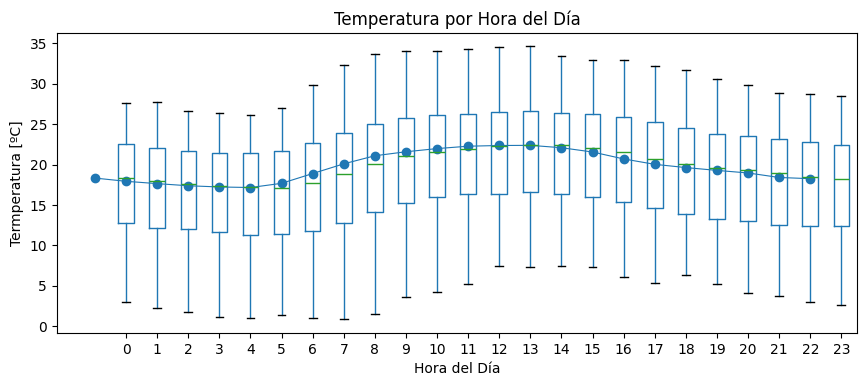

In [101]:
fig, ax = plt.subplots(figsize=(10, 4))
df4.boxplot(column='temperature_2m_C', by='Hour', ax=ax)
df4.groupby('Hour')['temperature_2m_C'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Termperatura [ºC]')
ax.set_xlabel('Hora del Día')
ax.set_title("Temperatura por Hora del Día")
fig.suptitle('')

## Relacion entre Demanda Energética y Temperatura. 

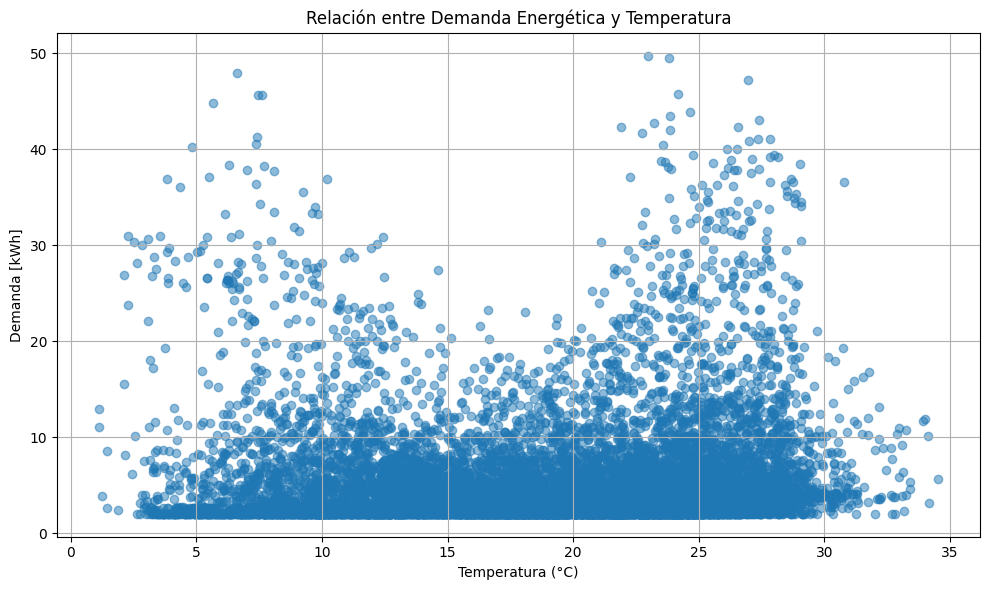

In [102]:
def plot_temp_vs_demand(df):
    df = df.copy(deep=True)
    df.set_index("Date", inplace=True)
    df_1h = df.resample('1h').mean()
    plt.figure(figsize=(10, 6))
    plt.scatter(df_1h['temperature_2m_C'], df_1h['Demanda_kWh'], alpha=0.5)
    plt.title('Relación entre Demanda Energética y Temperatura')
    plt.xlabel('Temperatura (°C)')
    plt.ylabel('Demanda [kWh]')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("../results/scatterplot_demanda_temp.png", bbox_inches='tight', dpi=300)
    plt.show()
plot_temp_vs_demand(df4)
# TODO rehacer este grafico, antes de aplicar la windsorizacion. 

Si hubiese buena correlacion entre la demanda y temperatura los puntos deberían formar una especie de "U", ya que cuanto mayor o menor sea la temperatura, mayor debería ser el consumo energético para mejorar el confort. Podemos apreciar que pasa en aquellos puntos donde la demanda tiene un valor bastante alto.

Por otro lado, los puntos en los bordes se deben a la winsorización de la temperatura en el preprocesamiento. 

## AutoCorrelation Plots

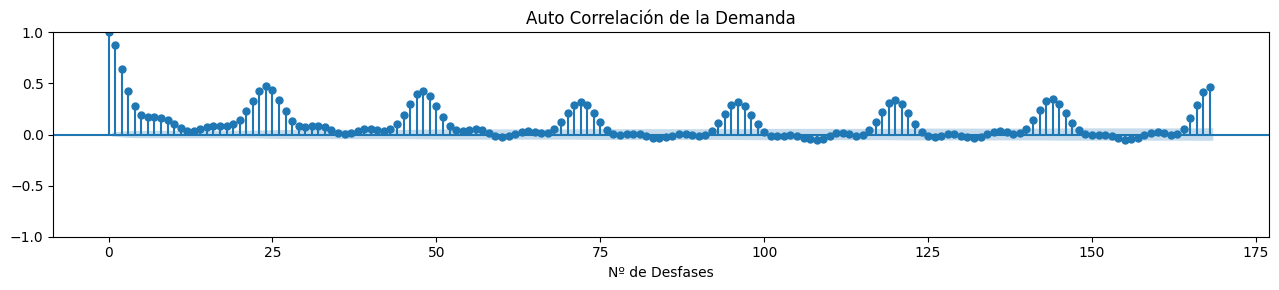

In [103]:
#Gráfico de autocorrelación 1
df4.set_index("Date", inplace=True)
demand_df_1h = df4.resample('1h').mean()
fig, ax = plt.subplots(figsize=(13, 3))
plt.xlabel("Nº de Desfases")
plot_acf(demand_df_1h["Demanda_kWh"], ax=ax, lags=24*7)
plt.title("Auto Correlación de la Demanda")
plt.tight_layout()
plt.savefig("../results/autocorrelacion.png", bbox_inches='tight', dpi=300)
plt.show()

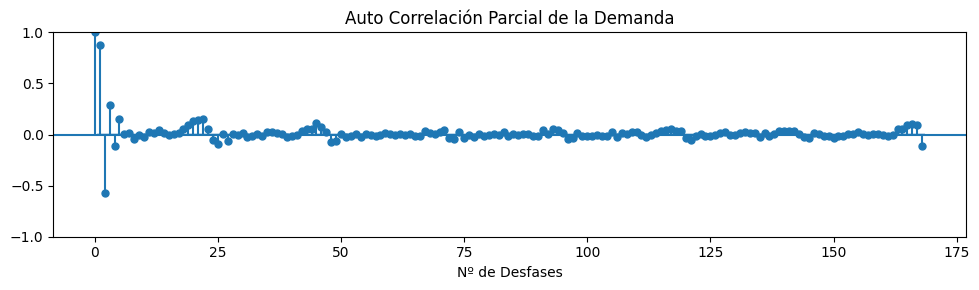

In [104]:
#Gráfico de autocorrelación parcial
fig, ax = plt.subplots(figsize=(10, 3))
plt.xlabel("Nº de Desfases")
plot_pacf(demand_df_1h["Demanda_kWh"], ax=ax, lags=24*7)
plt.title("Auto Correlación Parcial de la Demanda")
plt.tight_layout()
plt.savefig("../results/autocorrelacion_parcial.png", bbox_inches='tight', dpi=300)
plt.show()

## Correlation Matrix

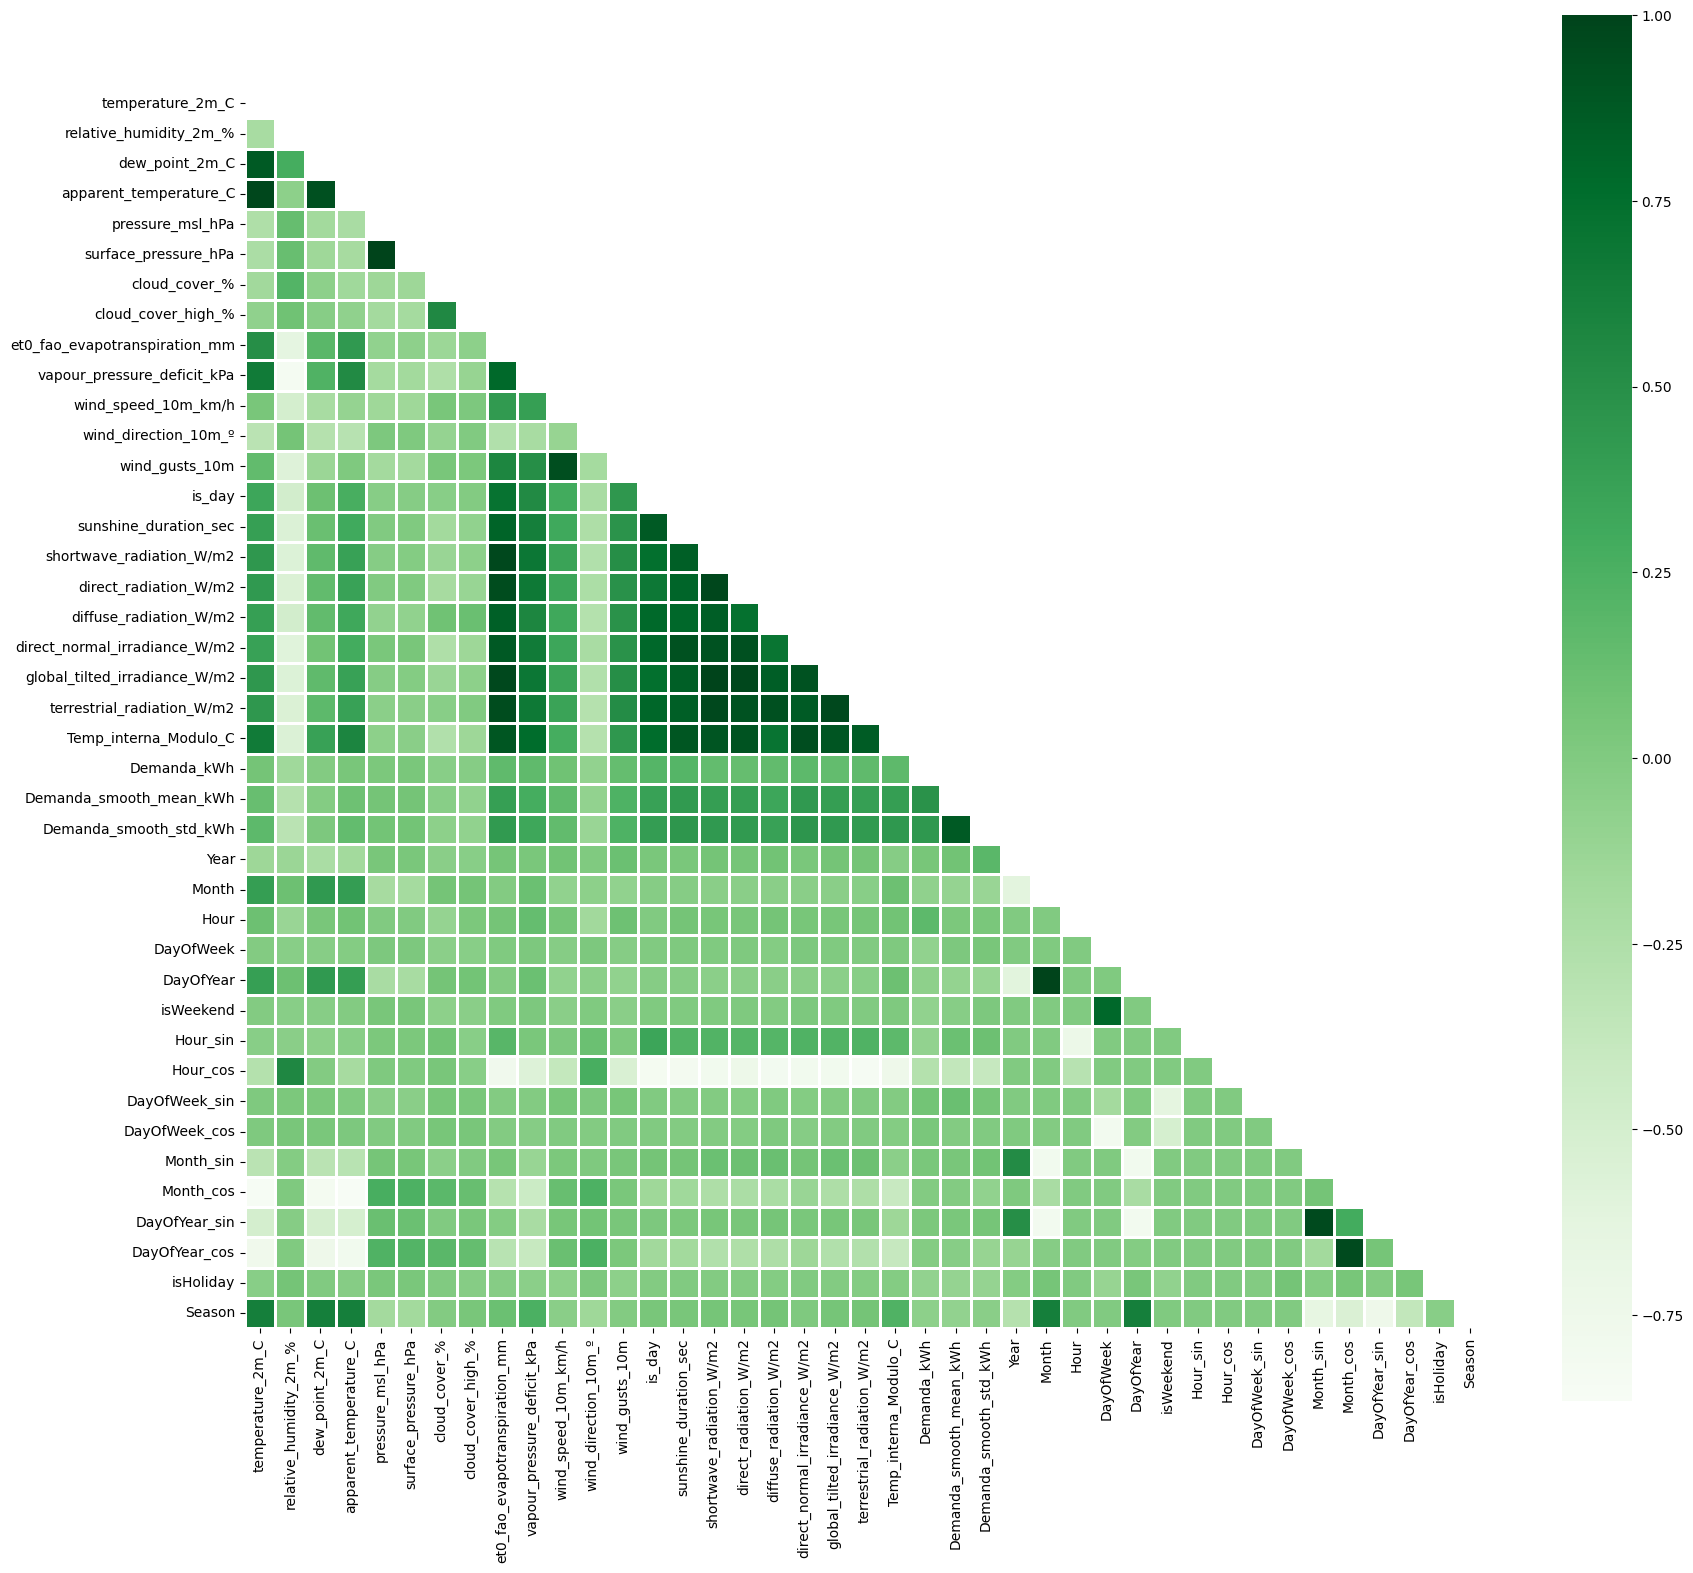

In [105]:
# Calcula la matriz de correlación completa
correlation_matrix = df4.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

# Imprime la matriz de correlación del cuadrante inferior
#plotting the heatmap for correlation
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, mask=mask, square=True, cmap='Greens', linewidths=2, linecolor='white');

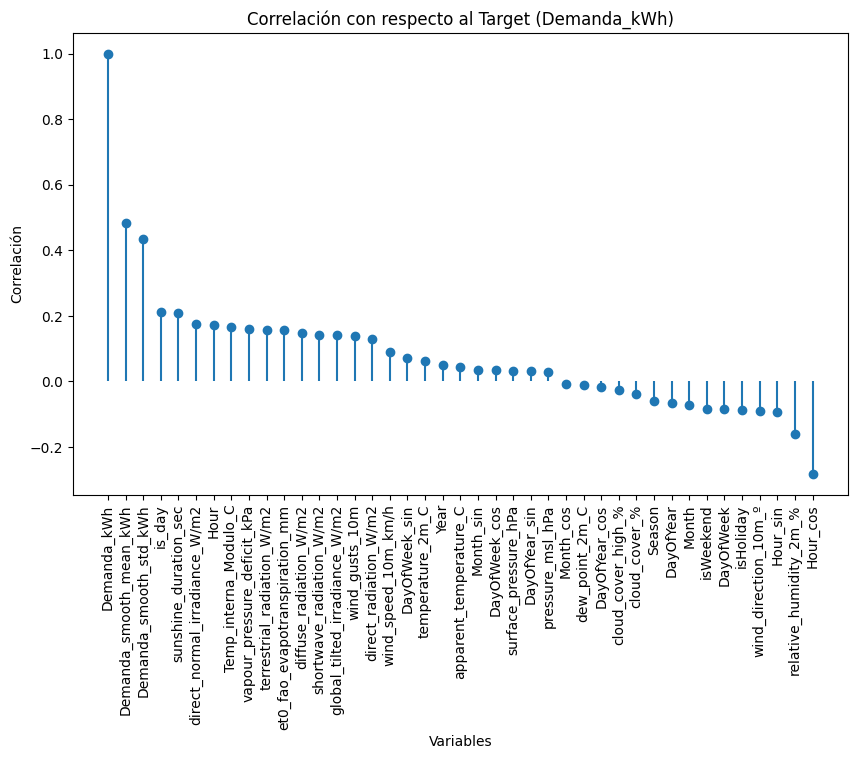

In [106]:
# VERSION LOLIPOP
# Ordenar el DataFrame de manera decreciente según la columna 'Consumo_kW'
sorted_correlation = correlation_matrix.sort_values(by='Demanda_kWh', ascending=False)

# Crear un gráfico lollipop de la correlación respecto a la variable específica
plt.figure(figsize=(10, 6))
plt.stem(sorted_correlation.index, sorted_correlation['Demanda_kWh'], basefmt=" ")
plt.title('Correlación con respecto al Target (Demanda_kWh)')
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.xticks(rotation=90)
plt.show()

# VERSION BARRAS
# # Ordenar el DataFrame de manera decreciente según la columna 'Consumo_kW'
# sorted_correlation = correlation_matrix.sort_values(by='Consumo_kW', ascending=False)

# # Crear un gráfico de barras de la correlación respecto a la variable específica
# plt.figure(figsize=(10, 6))
# sns.barplot(x=sorted_correlation.index, y=sorted_correlation['Consumo_kW'])
# plt.title('Correlación con respecto al Target (Consumo_kW)')
# plt.xlabel('Variables')
# plt.ylabel('Correlación')
# plt.xticks(rotation=90)
# plt.show()

## Time series decomposition

In [107]:
def decompose_time_series(df, column, freq):
    result = seasonal_decompose(df[column], model='additive', period=freq)
    df[f"{column}_trend"] = result.trend
    df[f"{column}_seasonal"] = result.seasonal
    df[f"{column}_residual"] = result.resid
    return df

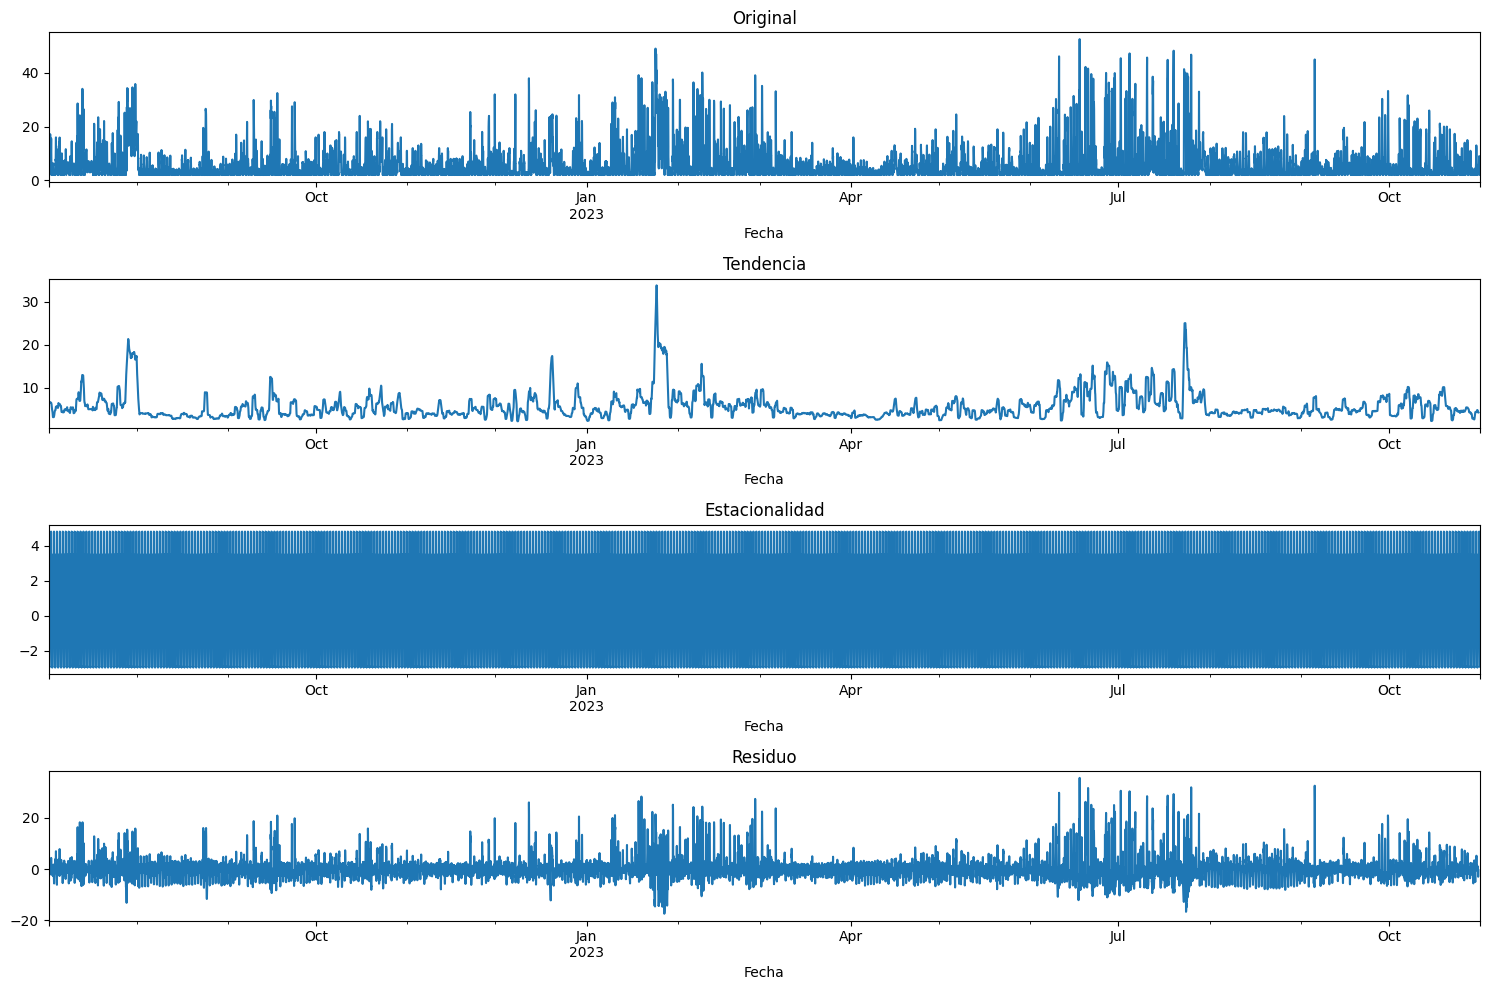

In [108]:
decomposed_df = decompose_time_series(df4, "Demanda_kWh", 96)

decomposed_df.reset_index(inplace=True, drop=False)

decomposed_df.set_index('Date', inplace=True)

# Plot the decomposed time series
fig, axes = plt.subplots(4, 1, figsize=(15, 10))
decomposed_df["Demanda_kWh"].plot(ax=axes[0],title="Original")
axes[0].set_xlabel("Fecha")
decomposed_df["Demanda_kWh_trend"].plot(ax=axes[1], title="Tendencia")
axes[1].set_xlabel("Fecha")
decomposed_df["Demanda_kWh_seasonal"].plot(ax=axes[2], title="Estacionalidad")
axes[2].set_xlabel("Fecha")
decomposed_df["Demanda_kWh_residual"].plot(ax=axes[3], title="Residuo")
axes[3].set_xlabel("Fecha")
plt.tight_layout()

plt.savefig("../results/seasonal_decompose.png", bbox_inches='tight', dpi=300)


In [109]:
df_seasonal = decomposed_df["Demanda_kWh_seasonal"]
df_seasonal = df_seasonal.loc[(df_seasonal.index >= pd.to_datetime('2022-01-08 0:00', format='%Y-%d-%m %H:%M'))]
df_seasonal = df_seasonal.loc[(df_seasonal.index <= pd.to_datetime('2022-10-08 0:00', format='%Y-%d-%m %H:%M'))]
grafico_zoom(df_seasonal.index, df_seasonal.values,
              "Patrón Estacional Diario de la Demanda", "Demanda (kWh)", filename="estacionalidad-diaria")

In [110]:
def getCluster(df):
    cluster_df = df.copy(deep=True)
    cluster_df = cluster_df.resample('1d').mean()
    cluster_df.reset_index(inplace=True)
    cluster_df = cluster_df[["Date", "temperature_2m_C"]]
    scaler = MinMaxScaler()
    cluster_df['temp_sta'] = scaler.fit_transform(cluster_df[["temperature_2m_C"]])
    dist_matrix = pdist(cluster_df[['temp_sta']], metric='euclidean')
    linked = linkage(dist_matrix, method="centroid")
    cluster_df['temp_cluster'] = fcluster(linked, 3, criterion='maxclust')

    #Gráfico del valor de la variable cluster
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=cluster_df.Date, y=cluster_df["temp_cluster"], mode='lines'))
    fig.update_layout(
        title = "Clusters de Temperaturas por Fechas",
        xaxis_title = "Fecha",
        yaxis_title = "Cluster de Temperatura",
        width = 850,
        height = 400,
        margin=dict(l=20, r=20, t=35, b=20),
        legend=dict(
            orientation="h",
            yanchor="top",
            y=1,
            xanchor="left",
            x=0.001
        )
    )
    fig.show()
    cluster_df.set_index("Date", inplace=True)
    return cluster_df

In [111]:
cluster_df = getCluster(df4)
df4

temperature_2m_C  relative_humidity_2m_%  dew_point_2m_C  \
Date                                                                            
2022-07-02 00:00:00         20.971500               81.949219       17.771502   
2022-07-02 00:15:00         20.496500               83.861229       17.659000   
2022-07-02 00:30:00         20.021500               85.773239       17.546501   
2022-07-02 00:45:00         19.546501               87.685249       17.434002   
2022-07-02 01:00:00         19.071500               89.597260       17.321500   
...                               ...                     ...             ...   
2023-10-31 23:00:00         13.571500               65.025040        7.121500   
2023-10-31 23:15:00         13.371500               65.779335        7.096500   
2023-10-31 23:30:00         13.171499               66.533630        7.071500   
2023-10-31 23:45:00         12.971499               67.287926        7.046500   
2023-11-01 00:00:00         12.771500               68.042221        7.021500   

                     apparent_temperature_C  pressure_msl_hPa  \
Date                                                            
2022-07-02 00:00:00               23.255192       1020.200012   
2022-07-02 00:15:00               22.657982       1020.075012   
2022-07-02 00:30:00               22.060772       1019.950012   
2022-07-02 00:45:00               21.463564       1019.825012   
2022-07-02 01:00:00               20.866354       1019.700012   
...                                     ...               ...   
2023-10-31 23:00:00               12.080925       1015.299988   
2023-10-31 23:15:00               11.873585       1015.224976   
2023-10-31 23:30:00               11.666244       1015.150024   
2023-10-31 23:45:00               11.458904       1015.075012   
2023-11-01 00:00:00               11.251564       1015.000000   

                     surface_pressure_hPa  cloud_cover_%  cloud_cover_high_%  \
Date                                                                           
2022-07-02 00:00:00           1014.413269       0.900000                0.00   
2022-07-02 00:15:00           1014.279602       0.675000                0.00   
2022-07-02 00:30:00           1014.145935       0.450000                0.00   
2022-07-02 00:45:00           1014.012268       0.225000                0.00   
2022-07-02 01:00:00           1013.878601       0.000000                0.00   
...                                   ...            ...                 ...   
2023-10-31 23:00:00           1009.392944      15.300001               17.00   
2023-10-31 23:15:00           1009.314270      16.725000               12.75   
2023-10-31 23:30:00           1009.235596      18.150002                8.50   
2023-10-31 23:45:00           1009.156860      19.575000                4.25   
2023-11-01 00:00:00           1009.078186      21.000000                0.00   

                     et0_fao_evapotranspiration_mm  \
Date                                                 
2022-07-02 00:00:00                       0.000000   
2022-07-02 00:15:00                       0.000000   
2022-07-02 00:30:00                       0.000000   
2022-07-02 00:45:00                       0.000000   
2022-07-02 01:00:00                       0.000000   
...                                            ...   
2023-10-31 23:00:00                       0.010180   
2023-10-31 23:15:00                       0.009510   
2023-10-31 23:30:00                       0.008841   
2023-10-31 23:45:00                       0.008171   
2023-11-01 00:00:00                       0.007502   

                     vapour_pressure_deficit_kPa  ...  DayOfWeek_cos  \
Date                                              ...                  
2022-07-02 00:00:00                     0.448133  ...        -0.9010   
2022-07-02 00:15:00                     0.393513  ...        -0.9010   
2022-07-02 00:30:00                     0.338893  ...        -0.9010   
2022-07-02 00:45:

In [112]:
cluster_df = cluster_df.resample('15T').ffill().reset_index()
df4 = df4.merge(cluster_df[["Date", "temp_cluster"]], on="Date", how='inner')
df4.reset_index(inplace=True, drop=True)
df4

Date  temperature_2m_C  relative_humidity_2m_%  \
0     2022-07-02 00:00:00         20.971500               81.949219   
1     2022-07-02 00:15:00         20.496500               83.861229   
2     2022-07-02 00:30:00         20.021500               85.773239   
3     2022-07-02 00:45:00         19.546501               87.685249   
4     2022-07-02 01:00:00         19.071500               89.597260   
...                   ...               ...                     ...   
46748 2023-10-31 23:00:00         13.571500               65.025040   
46749 2023-10-31 23:15:00         13.371500               65.779335   
46750 2023-10-31 23:30:00         13.171499               66.533630   
46751 2023-10-31 23:45:00         12.971499               67.287926   
46752 2023-11-01 00:00:00         12.771500               68.042221   

       dew_point_2m_C  apparent_temperature_C  pressure_msl_hPa  \
0           17.771502               23.255192       1020.200012   
1           17.659000               22.657982       1020.075012   
2           17.546501               22.060772       1019.950012   
3           17.434002               21.463564       1019.825012   
4           17.321500               20.866354       1019.700012   
...               ...                     ...               ...   
46748        7.121500               12.080925       1015.299988   
46749        7.096500               11.873585       1015.224976   
46750        7.071500               11.666244       1015.150024   
46751        7.046500               11.458904       1015.075012   
46752        7.021500               11.251564       1015.000000   

       surface_pressure_hPa  cloud_cover_%  cloud_cover_high_%  \
0               1014.413269       0.900000                0.00   
1               1014.279602       0.675000                0.00   
2               1014.145935       0.450000                0.00   
3               1014.012268       0.225000                0.00   
4               1013.878601       0.000000                0.00   
...                     ...            ...                 ...   
46748           1009.392944      15.300001               17.00   
46749           1009.314270      16.725000               12.75   
46750           1009.235596      18.150002                8.50   
46751           1009.156860      19.575000                4.25   
46752           1009.078186      21.000000                0.00   

       et0_fao_evapotranspiration_mm  ...  Month_sin  Month_cos  \
0                           0.000000  ...      0.000       -1.0   
1                           0.000000  ...      0.000       -1.0   
2                           0.000000  ...      0.000       -1.0   
3                           0.000000  ...      0.000       -1.0   
4                           0.000000  ...      0.000       -1.0   
...                              ...  ...        ...        ...   
46748                       0.010180  ...     -1.000       -0.0   
46749                       0.009510  ...     -1.000       -0.0   
46750                       0.008841  ...     -1.000       -0.0   
46751                       0.008171  ...     -1.000       -0.0   
46752                       0.007502  ...     -0.866        0.5   

       DayOfYear_sin  DayOfYear_cos  isHoliday  Season  Demanda_kWh_trend  \
0             0.0086        -1.0000      False       2                NaN   
1             0.0086        -1.0000      False       2                NaN   
2             0.0086        -1.0000      False       2                NaN   
3             0.0086        -1.0000      False       2                NaN   
4             0.0086        -1.0000      False       2                NaN   
...              ...            ...        ...     ...                ...   
46748        -0.8759         0.4825      False       3                NaN   
46749        -0.8759         0.4825      False       3                NaN   
46750        -0.8759         0.4825      False       3                Na

In [113]:
#Drop Columns
df4 = df4.drop(columns=["Demanda_smooth_mean_kWh", "Demanda_smooth_std_kWh", "Demanda_kWh_residual", "Demanda_kWh_seasonal", "Demanda_kWh_trend", "Year"])

### Save csv

In [114]:
# Guardar el DataFrame como CSV
nombre_archivo = "LaMonserratina_CLEAN.csv"
ruta_completa = os.path.join(ruta_data, nombre_archivo)
df4.to_csv(ruta_completa, index=False)